In [1]:
# Install pyspark and import that we will use
!pip install pyspark
from pyspark.sql.functions import avg, format_number, col, min as F_min, max as F_max, count, when

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812364 sha256=e2ae975bfbef0f81346da6453df1db22b80aac02f413b6ef58d9825ef6526a44
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
# Step 1: Load the new dataset and display the structure

# In PySpark, you begin by creating a Spark session. This is the starting point of any PySpark program.
from pyspark.sql import SparkSession

# Initialize the Spark session
spark = SparkSession.builder.appName("RealEstateAnalysis").getOrCreate()

# Set the log level to ERROR to avoid excessive logging information // Display only errors that prevent execution
spark.sparkContext.setLogLevel("ERROR")

# Next, we load the dataset. Since this is a CSV file, PySpark provides convenient methods to load and parse CSV files into DataFrames.
file_path = "/kaggle/input/usa-real-estate-dataset"
real_estate_df = spark.read.csv(file_path, header=True, inferSchema=True)

# To understand the structure of the dataset, we can print its schema
real_estate_df.printSchema()

# Display the first few rows to see what the data looks like
real_estate_df.show(10)

# Show all unique values in the 'state' column
real_estate_df.select("state").distinct().show()



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/29 14:32:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- brokered_by: double (nullable = true)
 |-- status: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bed: integer (nullable = true)
 |-- bath: integer (nullable = true)
 |-- acre_lot: double (nullable = true)
 |-- street: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip_code: integer (nullable = true)
 |-- house_size: double (nullable = true)
 |-- prev_sold_date: date (nullable = true)

+-----------+--------+--------+---+----+--------+---------+-------------+-----------+--------+----------+--------------+
|brokered_by|  status|   price|bed|bath|acre_lot|   street|         city|      state|zip_code|house_size|prev_sold_date|
+-----------+--------+--------+---+----+--------+---------+-------------+-----------+--------+----------+--------------+
|   103378.0|for_sale|105000.0|  3|   2|    0.12|1962661.0|     Adjuntas|Puerto Rico|     601|     920.0|          NULL|
|    52707.0|for_sale| 80000.0|  4|   2| 

+--------------------+
|               state|
+--------------------+
|                Ohio|
|        Pennsylvania|
|         Connecticut|
|             Vermont|
|         Puerto Rico|
|      Virgin Islands|
|District of Columbia|
|       New Brunswick|
|            Delaware|
|       West Virginia|
|            Missouri|
|        Rhode Island|
|             Georgia|
|            Virginia|
|            Michigan|
|      North Carolina|
|             Wyoming|
|          New Jersey|
|            Maryland|
|             Alabama|
+--------------------+
only showing top 20 rows



### Step 1 Recap:

In this step, we successfully loaded the new real estate dataset and examined its structure. Understanding the data's schema and inspecting the first few rows are important for deciding how to clean and transform the data in the following steps.


### Step 2: Data Cleaning and Transformation

In this step, we explore how to **clean and transform data** using PySpark, which is essential for preparing real-world datasets for analysis. The process involves selecting relevant columns, handling missing data, applying transformations, and filtering the dataset based on specific criteria.

1. **Column Selection**: Using the `select()` function, we extract only the necessary columns (e.g., price, bed, bath, house_size, etc) to focus on the data relevant for our analysis.
2. **Handling Missing Data**: We use the `dropna()` method to remove rows with missing critical fields such as `price` and `house_size`. This ensures that our dataset remains clean and reliable for further processing.
3. **Applying Transformations**: PySpark allows us to add new columns dynamically. Here, we create a new column `is_large_property`, which flags properties with a house size greater than 2000 square feet.
4. **Data Filtering**: We apply multiple filters to refine our dataset, such as ensuring properties have at least 3 bedrooms and 2 bathrooms, excluding houses with more than 8 bedrooms, and removing outliers with prices below $50,000 and house sizes exceeding 10,000 square feet.

This step showcases how PySpark can help in cleaning and preparing large datasets efficiently.


In [3]:
# Step 2: Data Cleaning and Transformation

# Print the initial number of rows before cleaning / This is just to look at our number of records before and after
initial_row_count = real_estate_df.count()
print(f"Number of rows before cleaning: {initial_row_count}")

# Step 2.1: Selecting relevant columns
# We're selecting columns that are relevant for analysis: price, bed, bath, house_size, zip_code and state
selected_columns_df = real_estate_df.select("price", "bed", "bath", "house_size", "zip_code", "state")

# Step 2.2: Handling missing data
# Drop rows where critical fields (like price, house_size and state) are null
cleaned_df = selected_columns_df.dropna(subset=["price", "house_size", "state"])

# Step 2.3: Applying transformations
# Creating a column that flags properties with more than 2000 square feet as 'large' properties
transformed_df = cleaned_df.withColumn("is_large_property", cleaned_df["house_size"] > 2000)

# Step 2.4: Filtering Data - Apply filters for bedroom and bathroom counts and exclude houses with more than 6 bedrooms, 
# with prices less than 50,000 and houses with more than 10,000 sqft and other filters
filtered_df = transformed_df.filter(
    (transformed_df["bed"] >= 2) & (transformed_df["bath"] >= 2) 
    & (transformed_df["bath"] <= 8)  & (transformed_df["bed"] <= 6) & (transformed_df["price"] >= 50000) 
    & (transformed_df["price"] <= 1500000) & (transformed_df["house_size"] <= 10000 ) 
)

# Print the final number of rows after cleaning and filtering
final_row_count = filtered_df.count()
print(f"Number of rows after cleaning and filtering: {final_row_count}")

# Display the first few rows of the cleaned and filtered dataset
filtered_df.show(5)


Number of rows before cleaning: 2226382


Number of rows after cleaning and filtering: 1266906
+--------+---+----+----------+--------+-----------+-----------------+
|   price|bed|bath|house_size|zip_code|      state|is_large_property|
+--------+---+----+----------+--------+-----------+-----------------+
|105000.0|  3|   2|     920.0|     601|Puerto Rico|            false|
| 80000.0|  4|   2|    1527.0|     601|Puerto Rico|            false|
|145000.0|  4|   2|    1800.0|     731|Puerto Rico|            false|
|179000.0|  4|   3|    2520.0|     612|Puerto Rico|             true|
| 71600.0|  3|   2|    1050.0|     731|Puerto Rico|            false|
+--------+---+----+----------+--------+-----------+-----------------+
only showing top 5 rows



### Step 2 Recap:

In this step, we used PySpark to clean and prepare the dataset for further analysis.

We also displayed the number of rows before and after cleaning and transformation to show how much data was filtered out.


### Step 3: Aggregating Data and Calculating Insights

In this step, we will group the data by the number of bedrooms and calculate useful summary statistics, such as the average price and average house size for each group. Aggregating data in this way helps reveal patterns and trends that may not be visible when looking at individual rows of data.

- **Data Aggregation**: Using PySpark's `groupBy()` and `agg()` functions to calculate aggregate values.

These calculations provide key insights into how the number of bedrooms in a property correlates with its price and size.


In [4]:
# Step 3: Aggregating Data and Calculating Insights

# Group the dataset by the number of bedrooms and calculate average price and house size
aggregated_data = filtered_df.groupBy("bed") \
    .agg(
        format_number(avg("price"), 2).alias("avg_price"),
        format_number(avg("house_size"), 2).alias("avg_house_size")
    ) \
    .orderBy("bed")

# Display the aggregated results
aggregated_data.show()

# Next step will show more examples on Aggregating Data


+---+----------+--------------+
|bed| avg_price|avg_house_size|
+---+----------+--------------+
|  2|391,994.71|      1,355.97|
|  3|411,602.85|      1,785.12|
|  4|517,043.68|      2,451.03|
|  5|632,729.18|      3,201.87|
|  6|642,716.62|      3,492.55|
+---+----------+--------------+



### Step 3 Recap:

In this step, we aggregated the data by grouping properties based on the number of bedrooms and calculating the average price and house size for each group. Aggregation helps us understand trends, such as how property size and price scale with the number of bedrooms.


### Step 4: Analyzing Price Trends and Distributions by State

In this step, we will use PySpark’s **grouping** and **aggregation** capabilities. PySpark enables us to compute summary statistics efficiently on large datasets distributed across multiple nodes, making it suitable for big data scenarios.

1. **State-wise Aggregation**: We use the `groupBy()` method to group properties by their respective states and apply aggregate functions like `avg()`, `min()`, `max()`, and `count()`. This allows us to calculate the average price, the minimum and maximum prices, and the number of properties for each state.

2. **Sorting and Formatting**: The data is first sorted using `orderBy()` before being formatted to two decimal places using `format_number()`. It's essential to note that formatting transforms numerical values into strings, which is why we apply sorting before formatting.

3. **Price Bucketing**: To analyze the price distribution within each state, we use the `when()` and `otherwise()` functions to create custom price buckets (e.g., "Below 100k", "100k-200k"). This is a feature in PySpark that allows us to define logical conditions and categorize data accordingly.

These techniques demonstrate how PySpark handles both complex aggregations and data transformation. 


In [5]:
# Step 4: Analyzing Price Trends and Distributions by State

# Calculate the average price of properties by state
state_price_trends = filtered_df.groupBy("state") \
    .agg(
        avg("price").alias("avg_price"),
        F_min("price").alias("min_price"),
        F_max("price").alias("max_price"),
        count("price").alias("num_properties")
    )

# Sort the data without formatting for correct sorting
sorted_highest_prices = state_price_trends.orderBy("avg_price", ascending=False)
sorted_lowest_prices = state_price_trends.orderBy("avg_price", ascending=True)

# Format columns to 2 decimal places after sorting
# Format transforms numbers into strings so orderBy or other functions will not work if we format before using them
formatted_highest_prices = sorted_highest_prices \
    .withColumn("avg_price", format_number("avg_price", 2)) \
    .withColumn("min_price", format_number("min_price", 2)) \
    .withColumn("max_price", format_number("max_price", 2)) \
    .withColumn("num_properties", format_number("num_properties", 0))

formatted_lowest_prices = sorted_lowest_prices \
    .withColumn("avg_price", format_number("avg_price", 2)) \
    .withColumn("min_price", format_number("min_price", 2)) \
    .withColumn("max_price", format_number("max_price", 2)) \
    .withColumn("num_properties", format_number("num_properties", 0))

# Display the states with the highest average prices
print("States with Highest Average Property Prices:")
formatted_highest_prices.show(10, truncate=False)

# Display the states with the lowest average prices
print("States with Lowest Average Property Prices:")
formatted_lowest_prices.show(10, truncate=False)


# We'll separate prices into ranges and see how many properties fall into each range per state

# Defining price rangers for distribution analysis
filtered_df = filtered_df.withColumn("price_range", 
                                     when(col("price") < 100000, "Below 100k")
                                     .when((col("price") >= 100000) & (col("price") < 200000), "100k-200k")
                                     .when((col("price") >= 200000) & (col("price") < 300000), "200k-300k")
                                     .when((col("price") >= 300000) & (col("price") < 400000), "300k-400k")
                                     .when((col("price") >= 400000) & (col("price") < 500000), "400k-500k")
                                     .when((col("price") >= 500000) & (col("price") < 1000000), "500k-1M")
                                     .when((col("price") >= 1000000) & (col("price") < 2000000), "1M-2M")
                                     .when((col("price") >= 2000000) & (col("price") < 3000000), "2M-3M")
                                     .otherwise("Above 3M"))

# Group by state and price range to analyze distribution of property prices in each state
price_distribution = filtered_df.groupBy("state", "price_range") \
    .agg(
        count("price").alias("num_properties")
    ) \
    .orderBy("state", "price_range")

# Display the price distribution in each state
print("Price Distribution by State:")
price_distribution.show(50, truncate=False)



States with Highest Average Property Prices:


+--------------------+----------+----------+------------+--------------+
|state               |avg_price |min_price |max_price   |num_properties|
+--------------------+----------+----------+------------+--------------+
|Hawaii              |806,681.57|79,900.00 |1,500,000.00|2,502         |
|District of Columbia|798,765.18|145,000.00|1,500,000.00|3,465         |
|California          |715,900.53|50,000.00 |1,500,000.00|138,993       |
|Washington          |630,486.10|50,000.00 |1,500,000.00|41,197        |
|Utah                |629,620.20|51,000.00 |1,500,000.00|8,859         |
|Colorado            |611,178.66|50,000.00 |1,500,000.00|18,978        |
|Massachusetts       |609,091.35|50,000.00 |1,500,000.00|23,436        |
|Virgin Islands      |589,238.40|99,500.00 |1,499,000.00|108           |
|Idaho               |582,767.91|50,000.00 |1,500,000.00|10,547        |
|Oregon              |571,728.76|50,000.00 |1,500,000.00|20,907        |
+--------------------+----------+----------+-------

+-------------+----------+---------+------------+--------------+
|state        |avg_price |min_price|max_price   |num_properties|
+-------------+----------+---------+------------+--------------+
|Ohio         |273,303.13|50,000.00|1,500,000.00|32,936        |
|West Virginia|277,431.78|50,000.00|1,500,000.00|6,001         |
|Iowa         |292,055.69|50,000.00|1,500,000.00|13,924        |
|Oklahoma     |294,235.62|50,000.00|1,500,000.00|23,740        |
|Mississippi  |299,566.84|50,000.00|1,500,000.00|7,781         |
|Kentucky     |306,860.73|50,000.00|1,500,000.00|13,341        |
|Louisiana    |317,774.75|50,000.00|1,500,000.00|14,394        |
|Puerto Rico  |324,573.99|50,000.00|1,500,000.00|1,604         |
|Arkansas     |326,122.22|50,000.00|1,500,000.00|10,357        |
|Missouri     |327,932.21|50,000.00|1,500,000.00|25,631        |
+-------------+----------+---------+------------+--------------+
only showing top 10 rows

Price Distribution by State:


+-----------+-----------+--------------+
|state      |price_range|num_properties|
+-----------+-----------+--------------+
|Alabama    |100k-200k  |3614          |
|Alabama    |1M-2M      |360           |
|Alabama    |200k-300k  |4575          |
|Alabama    |300k-400k  |3443          |
|Alabama    |400k-500k  |1903          |
|Alabama    |500k-1M    |2588          |
|Alabama    |Below 100k |750           |
|Alaska     |100k-200k  |30            |
|Alaska     |1M-2M      |20            |
|Alaska     |200k-300k  |71            |
|Alaska     |300k-400k  |124           |
|Alaska     |400k-500k  |164           |
|Alaska     |500k-1M    |257           |
|Alaska     |Below 100k |7             |
|Arizona    |100k-200k  |2076          |
|Arizona    |1M-2M      |1799          |
|Arizona    |200k-300k  |7081          |
|Arizona    |300k-400k  |12359         |
|Arizona    |400k-500k  |11442         |
|Arizona    |500k-1M    |14832         |
|Arizona    |Below 100k |409           |
|Arkansas   |100

### Step 4 Recap:

In this step, we explored price trends and distributions across different states. We calculated the average, minimum, and maximum property prices by state.

Additionally, we analyzed the distribution of property prices within each state by categorizing prices into various ranges (ex: "Below 100k", "100k-200k", etc.). This allows us to better understand the spread of property values in different regions.

### Step 5: Visualizing Price Trends by Property Size, Price Distribution, and Bedroom-Price Relationship

In this step, we will use Python libraries, **Matplotlib** and **Seaborn** for visualizations.

Once we've processed and filtered our dataset using PySpark, we convert it into a **Pandas DataFrame** for visualization purposes. By converting the PySpark DataFrame to a Pandas DataFrame, we bring the data into a format that Matplotlib and Seaborn can easily handle for visualization.

1. **Scatter Plot (Price vs. House Size)**: We generate a scatter plot to visualize the relationship between house size (in square feet) and price (in USD). PySpark’s distributed computing handles the data preparation, and Matplotlib helps visualize it. Additionally, we plot state-specific scatter plots to compare regional trends.

2. **Histogram (Distribution of Property Prices)**: A histogram helps us visualize how property prices are distributed across the dataset. PySpark processes the data and hands it over to Matplotlib for visualization.

3. **Box Plot (Price vs. Number of Bedrooms)**: Seaborn, built on top of Matplotlib, provides higher-level plotting tools. Here, we use Seaborn to create a box plot to analyze the price distribution across properties with different numbers of bedrooms.



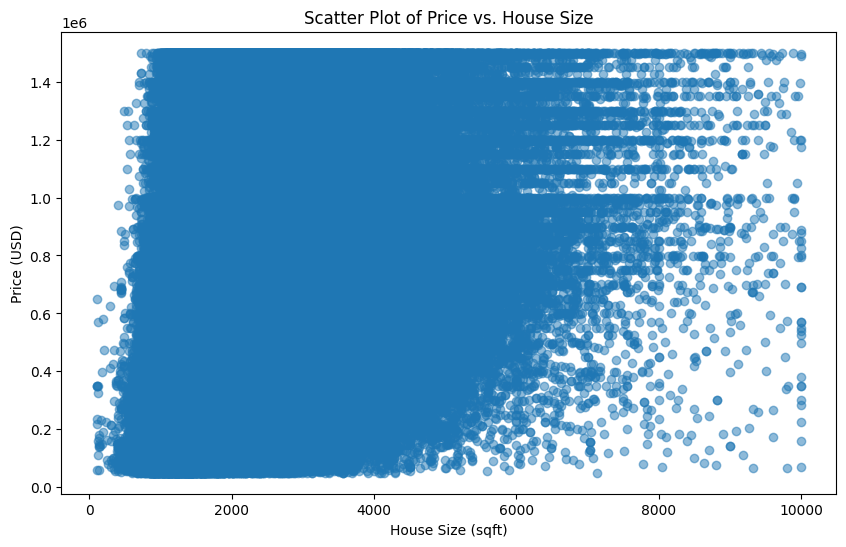

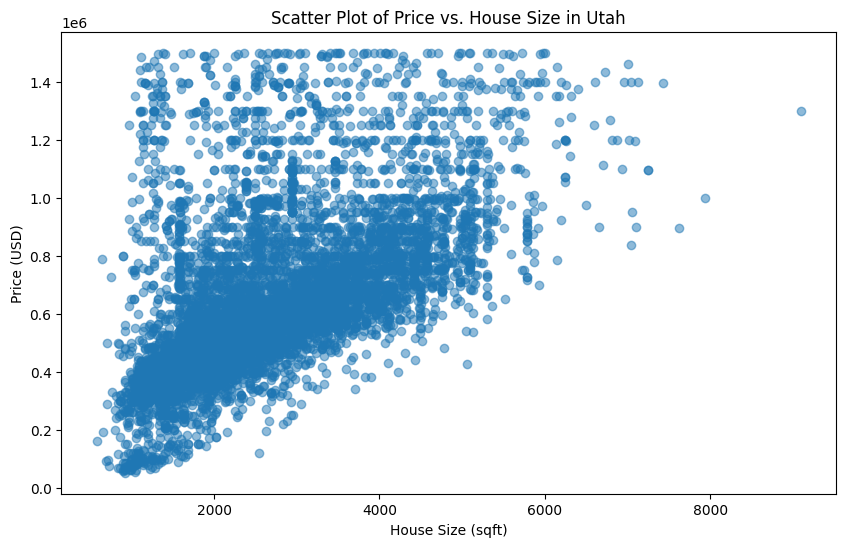

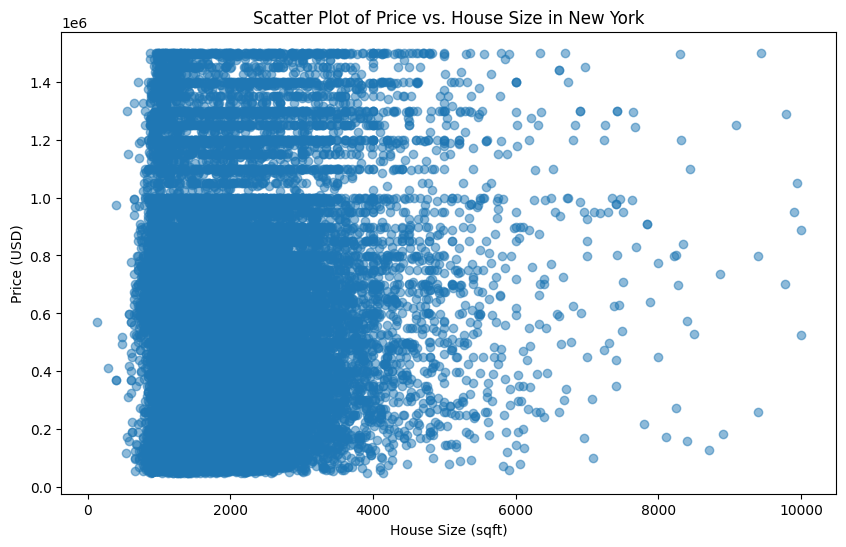

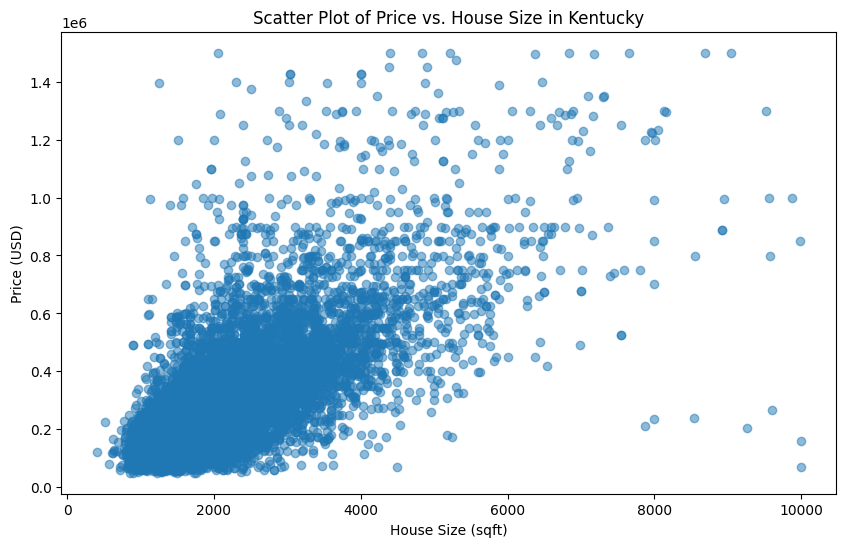

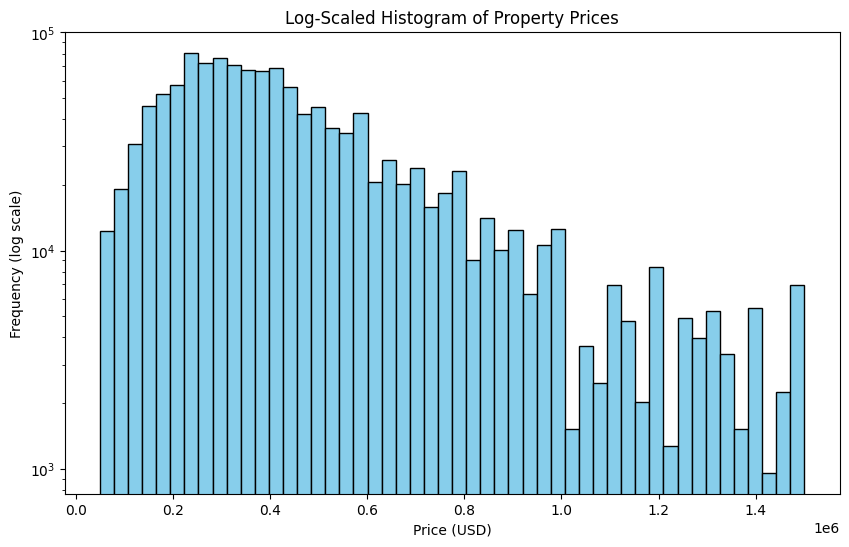

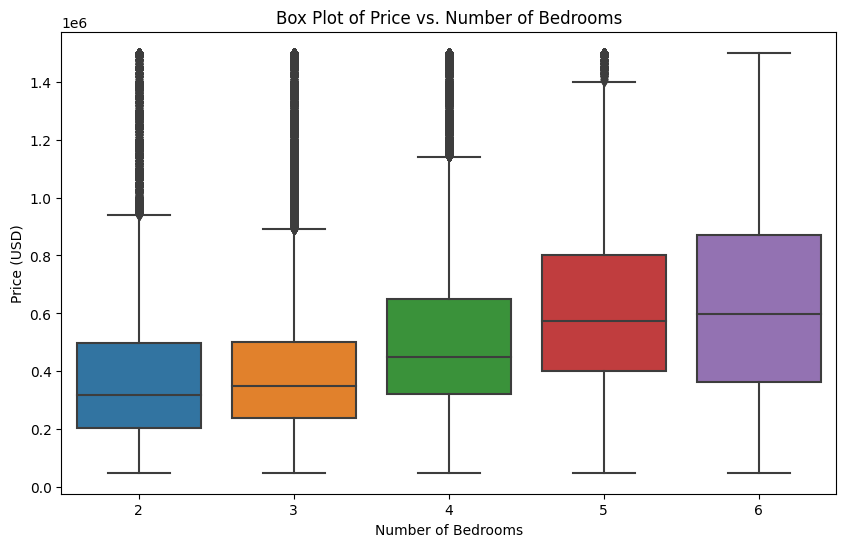

In [6]:
# Step 5: Visualizing Price Trends by Property Size, Price Distribution, and Bedroom-Price Relationship

import matplotlib.pyplot as plt
import seaborn as sns

# Convert the filtered Spark DataFrame to a Pandas DataFrame for visualization
pandas_df = filtered_df.select("price", "house_size", "bed", "state").toPandas()

# Visualization 1: Scatter Plot - Price vs. House Size
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['house_size'], pandas_df['price'], alpha=0.5)
plt.title('Scatter Plot of Price vs. House Size')
plt.xlabel('House Size (sqft)')
plt.ylabel('Price (USD)')
plt.show()

# State-Specific Scatter Plot
states_to_plot = ['Utah', 'New York', 'Kentucky']
for state in states_to_plot:
    state_data = pandas_df[pandas_df['state'] == state]
    plt.figure(figsize=(10, 6))
    plt.scatter(state_data['house_size'], state_data['price'], alpha=0.5) # Alpha is for transparency of the dots 50%
    plt.title(f'Scatter Plot of Price vs. House Size in {state}')
    plt.xlabel('House Size (sqft)')
    plt.ylabel('Price (USD)')
    plt.show()

# Visualization 2: Histogram - Distribution of Property Prices
plt.figure(figsize=(10, 6))
plt.hist(pandas_df['price'], bins=50, color='skyblue', edgecolor='black', log=True)  # Log scale for better visualization
plt.title('Log-Scaled Histogram of Property Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency (log scale)')
plt.show()


# Visualization 3: Box Plot - Price vs. Number of Bedrooms
plt.figure(figsize=(10, 6))
sns.boxplot(x='bed', y='price', data=pandas_df)
plt.title('Box Plot of Price vs. Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price (USD)')
plt.show()




### Step 5 Recap:

Here, we integrated **PySpark** with **Matplotlib** and **Seaborn** to explore different ways of visualizing our data.

With these visualizations, we provide a more accessible and interactive way to understand the data. Through the use of PySpark for data handling and Python libraries for visualization.


### Step 6: Building a Simple Machine Learning Model with PySpark
In this step, we will explore how to build a basic Linear Regression model using PySpark’s MLlib library. This is a great introduction to machine learning with PySpark because it lets us harness Spark's distributed computing power for model training and evaluation.

PySpark's MLlib provides a scalable machine learning library that supports a variety of algorithms.

Here, we will walk through:

Data Preparation: We'll use VectorAssembler to consolidate multiple features (like bedrooms, bathrooms, and house size) into a single vector that the machine learning algorithm can process.
Training the Model: We’ll fit the model using the LinearRegression class, which is simple and intuitive to understand.
Evaluation: Finally, we’ll evaluate the model using RegressionEvaluator to check how well it performs using the RMSE (Root Mean Squared Error) metric.
This step introduces key PySpark MLlib classes like LinearRegression, VectorAssembler, and RegressionEvaluator, which are essential for performing machine learning tasks in PySpark.

Build the model (LinearRegression),
Prepare the data (VectorAssembler), and
Measure performance (RegressionEvaluator).

In [7]:
# Step 6: Building a Machine Learning Model - Linear Regression

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Step 6.1: Data Preparation

# Selecting relevant features for the model
ml_df = filtered_df.select("price", "bed", "bath", "house_size")

# Assembling the features into a single vector column for the model
assembler = VectorAssembler(inputCols=["bed", "bath", "house_size"], outputCol="features")
ml_df = assembler.transform(ml_df).select("features", "price")

# Step 6.2: Splitting the Data into Training and Testing Sets

train_data, test_data = ml_df.randomSplit([0.8, 0.2], seed=15)

# Step 6.3: Creating and Training the Linear Regression Model

# Initializing the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='price')

# Fitting the model on the training data
lr_model = lr.fit(train_data)

# Step 6.4: Evaluating the Model

# Predicting on the test data
test_results = lr_model.transform(test_data)

# Evaluating the model using RMSE (Root Mean Squared Error)
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="rmse")
rmse = evaluator.evaluate(test_results)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Step 6.5: Analyzing the Model Coefficients and Intercept

print(f"Coefficients: {lr_model.coefficients}")


Root Mean Squared Error (RMSE): 245438.09788340802
Coefficients: [-19607.602648210493,83457.46219316014,102.07763827226628]


### Step 6 Recap:
In this section, we applied PySpark’s MLlib to create and evaluate a simple Linear Regression model.

After training the model, we got an RMSE of around 203,572. It tells us how far off our predictions are from the actual property prices, on average. While it's not accurate, it does show that the model is at least somewhat on track, though there's definitely a lot room for improvement.

Looking at the coefficients, they represent how much each feature (like number of bedrooms, bathrooms, house size, and the state) influences the predicted price. Some are positive (meaning the price increases with that feature), while the numbers for bed are negative (meaning the price decreases as more beds, which is not accurate). 

Conclusion: If we want better accuracy, we could try adding things—maybe do more preprocessing, engineer some new features, or even experiment with different types of models that might handle the complexity better than a simple linear regression such as decision trees or gradient boosting. 

### Extra Step: SQL Queries vs PySpark DataFrame Operations

SQL Queries vs PySpark DataFrames
One of the most valuable aspects of working with PySpark is how it closely mimics SQL queries, making it easy for SQL users to adapt to PySpark’s DataFrame API. This extra step will help to see common SQL queries and their equivalents in PySpark.

In [9]:
# Extra: SQL vs. PySpark Comparison

# Register the DataFrame as a temporary SQL view
real_estate_df.createOrReplaceTempView("real_estate")

# SQL Query 1: Select Specific Columns
print("SQL Query 1 - Select Specific Columns:")
spark.sql("SELECT price, bed, bath FROM real_estate").show()

# PySpark Equivalent:
print("PySpark Equivalent:")
real_estate_df.select("price", "bed", "bath").show()

# ---------------------------------------------------

# SQL Query 2: Filtering Data
print("SQL Query 2 - Filtering Data:")
spark.sql("SELECT * FROM real_estate WHERE price > 200000").show()

# PySpark Equivalent:
print("PySpark Equivalent:")
real_estate_df.filter(real_estate_df["price"] > 200000).show()

# ---------------------------------------------------

# SQL Query 3: Aggregating Data
print("SQL Query 3 - Aggregating Data:")
spark.sql("SELECT AVG(price) as avg_price FROM real_estate").show()

# PySpark Equivalent:
print("PySpark Equivalent:")
real_estate_df.agg(avg("price").alias("avg_price")).show()

# ---------------------------------------------------

# SQL Query 4: Grouping Data
print("SQL Query 4 - Grouping Data:")
spark.sql("SELECT bed, AVG(price) as avg_price FROM real_estate GROUP BY bed").show()

# PySpark Equivalent:
print("PySpark Equivalent:")
real_estate_df.groupBy("bed").agg(avg("price").alias("avg_price")).show()

# ---------------------------------------------------

# SQL Query 5: Sorting Data
print("SQL Query 5 - Sorting Data:")
spark.sql("SELECT * FROM real_estate ORDER BY price DESC").show()

# PySpark Equivalent:
print("PySpark Equivalent:")
real_estate_df.orderBy(real_estate_df["price"].desc()).show()

# ---------------------------------------------------

# SQL Query 6: Joining Tables (2 tables)
# SELECT a.price, b.bed FROM real_estate a JOIN another_table b ON a.id = b.id;
# PySpark Equivalent (2 tables):
# real_estate.join(another_table, real_estate["id"] == another_table["id"]).select(real_estate["price"], another_table["bed"]).show()



SQL Query 1 - Select Specific Columns:
+--------+---+----+
|   price|bed|bath|
+--------+---+----+
|105000.0|  3|   2|
| 80000.0|  4|   2|
| 67000.0|  2|   1|
|145000.0|  4|   2|
| 65000.0|  6|   2|
|179000.0|  4|   3|
| 50000.0|  3|   1|
| 71600.0|  3|   2|
|100000.0|  2|   1|
|300000.0|  5|   3|
| 89000.0|  3|   2|
|150000.0|  3|   2|
|155000.0|  3|   2|
| 79000.0|  5|   2|
|649000.0|  5|   5|
|120000.0|  3|   2|
|235000.0|  4|   4|
|105000.0|  3|   2|
|575000.0|  3|   2|
|140000.0|  6|   3|
+--------+---+----+
only showing top 20 rows

PySpark Equivalent:
+--------+---+----+
|   price|bed|bath|
+--------+---+----+
|105000.0|  3|   2|
| 80000.0|  4|   2|
| 67000.0|  2|   1|
|145000.0|  4|   2|
| 65000.0|  6|   2|
|179000.0|  4|   3|
| 50000.0|  3|   1|
| 71600.0|  3|   2|
|100000.0|  2|   1|
|300000.0|  5|   3|
| 89000.0|  3|   2|
|150000.0|  3|   2|
|155000.0|  3|   2|
| 79000.0|  5|   2|
|649000.0|  5|   5|
|120000.0|  3|   2|
|235000.0|  4|   4|
|105000.0|  3|   2|
|575000.0|  3| 

+-----------------+
|        avg_price|
+-----------------+
|524195.5192906774|
+-----------------+

PySpark Equivalent:


+-----------------+
|        avg_price|
+-----------------+
|524195.5192906774|
+-----------------+

SQL Query 4 - Grouping Data:


+----+------------------+
| bed|         avg_price|
+----+------------------+
|  31|         3785332.5|
|  53|         6900000.0|
|  34| 4650714.285714285|
|  28|3496972.3421052634|
| 210|          575000.0|
|  27|2493690.8695652173|
|  26|3331280.9523809524|
|  44| 4814285.714285715|
|  12|  2609231.76042677|
|  22|       3670463.625|
|  47|3251166.6666666665|
|NULL| 317485.9624922795|
|   1|372766.03488068347|
|  13|3118753.1867219917|
|   6|1605613.3205490513|
|  16| 2453852.933333333|
|  86|           1.515E7|
|   3| 451811.0108583173|
| 142|         2100000.0|
|  20| 2957435.168067227|
+----+------------------+
only showing top 20 rows

PySpark Equivalent:


+----+------------------+
| bed|         avg_price|
+----+------------------+
|  31|         3785332.5|
|  53|         6900000.0|
|  34| 4650714.285714285|
|  28|3496972.3421052634|
| 210|          575000.0|
|  27|2493690.8695652173|
|  26|3331280.9523809524|
|  44| 4814285.714285715|
|  12|  2609231.76042677|
|  22|       3670463.625|
|  47|3251166.6666666665|
|NULL| 317485.9624922795|
|   1|372766.03488068347|
|  13|3118753.1867219917|
|   6|1605613.3205490513|
|  16| 2453852.933333333|
|  86|           1.515E7|
|   3| 451811.0108583173|
| 142|         2100000.0|
|  20| 2957435.168067227|
+----+------------------+
only showing top 20 rows

SQL Query 5 - Sorting Data:


+-----------+--------+-----------+----+----+--------+---------+-------------+----------+--------+----------+--------------+
|brokered_by|  status|      price| bed|bath|acre_lot|   street|         city|     state|zip_code|house_size|prev_sold_date|
+-----------+--------+-----------+----+----+--------+---------+-------------+----------+--------+----------+--------------+
|    23826.0|for_sale|2.1474836E9|   2|   2|    0.12|  11355.0|International|California|    NULL|     885.0|          NULL|
|   104341.0|for_sale|      1.0E9|NULL|NULL|   101.0| 129645.0|       Eureka|    Kansas|   67045|      NULL|          NULL|
|   100472.0|for_sale|     8.75E8|   9|   2|    NULL|1811391.0|        Bronx|  New York|   10458|    2440.0|    2002-12-30|
|    13872.0|for_sale|     5.15E8|   2|   2|    2.59|1658312.0|    San Diego|California|   92119|    1048.0|    2018-04-17|
|    16829.0|    sold|     2.95E8|  21|  49|    3.83|1805321.0|  Los Angeles|California|   90077|      NULL|    2022-03-30|
|    706

+-----------+--------+-----------+----+----+--------+---------+-------------+----------+--------+----------+--------------+
|brokered_by|  status|      price| bed|bath|acre_lot|   street|         city|     state|zip_code|house_size|prev_sold_date|
+-----------+--------+-----------+----+----+--------+---------+-------------+----------+--------+----------+--------------+
|    23826.0|for_sale|2.1474836E9|   2|   2|    0.12|  11355.0|International|California|    NULL|     885.0|          NULL|
|   104341.0|for_sale|      1.0E9|NULL|NULL|   101.0| 129645.0|       Eureka|    Kansas|   67045|      NULL|          NULL|
|   100472.0|for_sale|     8.75E8|   9|   2|    NULL|1811391.0|        Bronx|  New York|   10458|    2440.0|    2002-12-30|
|    13872.0|for_sale|     5.15E8|   2|   2|    2.59|1658312.0|    San Diego|California|   92119|    1048.0|    2018-04-17|
|    16829.0|    sold|     2.95E8|  21|  49|    3.83|1805321.0|  Los Angeles|California|   90077|      NULL|    2022-03-30|
|    706